# Advanced Statistics for Physics Analysis 2020 - 2021
## Exercises on the last parts of the lectures: MCMC, Gibbs Sampling, JAGS

In [1]:
#install.packages('tidyverse')
options(repr.plot.width=4, repr.plot.height=3)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Exercise 1: Island Example (MCMC)

In [2]:
island.pop  <- seq(from = 1,to = 10,by = 1)*1000
island.x    <- seq(from = 1,to = 10,by = 1)

island <- data.frame(x = island.x, pop = island.pop)

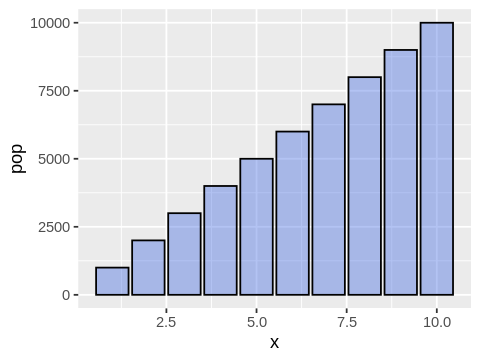

In [3]:
ggplot(island) + geom_bar(aes(x=x, y=pop), stat="identity",fill=I("royalblue"),col=I("black"),alpha=.4)

In [4]:
# We want to sample from that distribution
coin <- c(TRUE,FALSE)

In [5]:
islandsMCMC <- function(steps, burnin)
    {
        counts <- rep(0,10)
        # pos is the position, at the beginning it is randomly chosen
        pos <- sample(1:10,1)
        
        coin <- c(TRUE,FALSE) #HEAD, TAIL 
        for(i in 1:burnin)
            {
                # flip of the coin
                ifelse(sample(coin,1) == TRUE, prop <- pos - 1, prop <- pos + 1)
                if(prop == 11){prop <- 1}
                if(prop==0){prop <- 10}
            
                pratio <- island.pop[prop] / island.pop[pos] # Pproposed/Pcurrent
                if(pratio>1) # we move there
                    {
                        pos <- prop
                    }
                else
                    {
                        # generate a random number, if it is lower than the ratio we move
                        prob <- runif(1,0,1)
                        if(prob < pratio)
                            {
                                pos <- prop
                            }
                    }
            }
        for(i in 1:steps)
            {
                # flip of the coin
                ifelse(sample(coin,1) == TRUE, prop <- pos - 1, prop <- pos + 1)
                if(prop == 11){prop <- 1}
                if(prop==0){prop <- 10}
            
                pratio <- island.pop[prop] / island.pop[pos] # Pproposed/Pcurrent
                if(pratio>1) # we move there
                    {
                        pos <- prop
                        counts[pos] <- counts[pos] + 1
                    }
                else
                    {
                        # generate a random number, if it is lower than the ratio we move
                        prob <- runif(1,0,1)
                        if(prob < pratio)
                            {
                                pos <- prop
                                counts[pos] <- counts[pos] + 1
                            }
                        else
                            {
                                counts[pos] <- counts[pos] + 1
                            }
                    }
            }
    
        return(counts)
    
    }

In [6]:
histo <- islandsMCMC(100000,1000)

mcislands <- data.frame(y=histo,x=island.x)

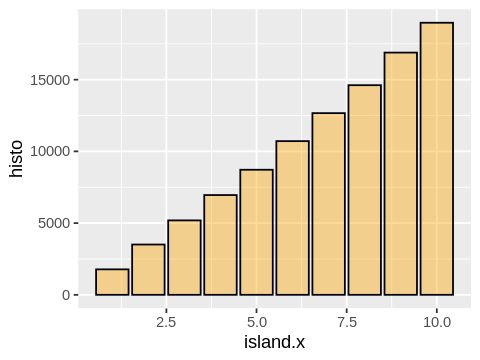

In [7]:
ggplot(mcislands) + geom_bar(aes(x=island.x, y=histo), stat="identity",fill=I("orange"),col=I("black"),alpha=.4)

## Exercise 2: Sampling from a Cauchy Distribution (MCMC)

In [2]:
# This is just copied from the slides

In [48]:
# Parameters:
#  > func : a function whose first argument is a real vector of parameters, func returns a log 10
#           of the likelihood function
#  > theta.init : the initial value of the Markov Chain (and of func)
#  > n.sample: number of required samples
#  > sigma : standard deviation of the gaussian MCMC sampling pdf
metropolis.1dim <- function(func, theta.init, n.sample, sigma)
    {
        theta.cur <- theta.init
        func.Cur <- func(theta.cur)
        func.Samp <- matrix(data=NA, nrow=n.sample, ncol=2+1) # to do some plot
        n.accept <- 0
        rate.accept <- 0.0
    
        for(n in 1:n.sample)
            {
                theta.prop <- rnorm(n=1, mean = theta.cur, sigma)
                func.Prop <- func(theta.prop)
                logMR <- func.Prop - func.Cur # Log10 of the Metropolis ratio
            
                if(logMR>=0||logMR>log10(runif(1)))
                    {
                        theta.cur <- theta.prop
                        func.Cur <- func.Prop
                        n.accept <- n.accept + 1
                    }
                func.Samp[n, 1] <- func.Cur
                func.Samp[n, 2] <- theta.cur
            }
        return(func.Samp)
    }

In [59]:
# Our test function
testfunc <- function(theta)
    {
        return(dcauchy(theta, -10, 2,) + 4*dcauchy(theta, 10, 4))
    }

#
# - interface for the metropolis function, gets the log10 of test function
testfunc.metropolis <- function(theta)
    {
        return(log10(testfunc(theta)))
    }

### Running parameters
theta.init <- -5
sample.sig <- 10
n.sample   <- 100000

set.seed(20190513)
chain <- metropolis.1dim(func       = testfunc.metropolis,
                         theta.init = theta.init,
                         n.sample   = n.sample,
                         sigma      = sample.sig^2)

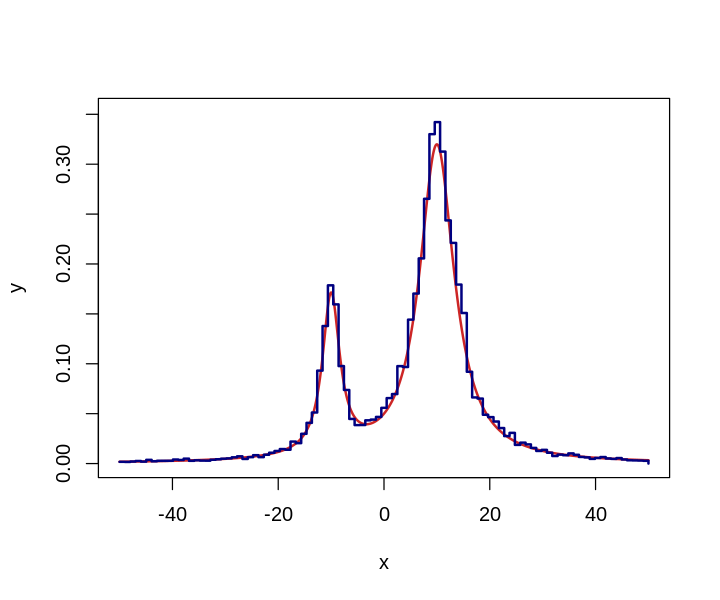

In [65]:
x <- seq(-50, 50, length.out = 10^4)
y <- testfunc(x)
Zfunc <- 5
ymax <- 1.05 * max(y)
plot(x, y, ylim=c(0,max(y)*1.1), type='l', lwd=2, col='firebrick3')

sa <- which(chain[,2]>=min(x) & chain[,2]<=max(x))
hist <- hist(chain[sa,2], breaks=seq(from=min(x), to=max(x), length.out=100), plot=FALSE)
Zhist <- sum(hist$counts)*diff(range(hist$breaks))/length(hist$counts)
lines(hist$breaks, c(hist$counts*Zfunc/Zhist,0), col='navy', type="s", lwd = 2, lty=1)

## Exercise 3: JAGS

#### 3.1 Bernoulli process

In [2]:
library(rjags)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



In [9]:
X <- c(0, 0, 0, 0, 0, 0, 0, 1, 0, 0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1,0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0,0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0,0, 0, 0, 0, 1, 0, 0, 1, 0, 1)

data <- NULL
data$X <- X # set of observations
data$n <- length(X)

data$n_next <- 10

jm <- jags.model('jags1.bug' , data)

Warning message in jags.model("jags1.bug", data):
“Unused variable "n" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 2
   Total graph size: 104

Initializing model



In [10]:
# Update the Markov chain (Burn-in)
update(jm, 1000)
chain <- coda.samples(jm, c('p', 'y'), n.iter=10000)
print(summary(chain))


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

    Mean      SD  Naive SE Time-series SE
p 0.1664 0.03639 0.0003639      0.0003639
y 1.6615 1.22746 0.0122746      0.0125260

2. Quantiles for each variable:

    2.5%    25%   50%    75%  97.5%
p 0.1022 0.1408 0.164 0.1895 0.2447
y 0.0000 1.0000 2.000 2.0000 4.0000




 Correlation matrix: 
          p         y
p 1.0000000 0.3069968
y 0.3069968 1.0000000


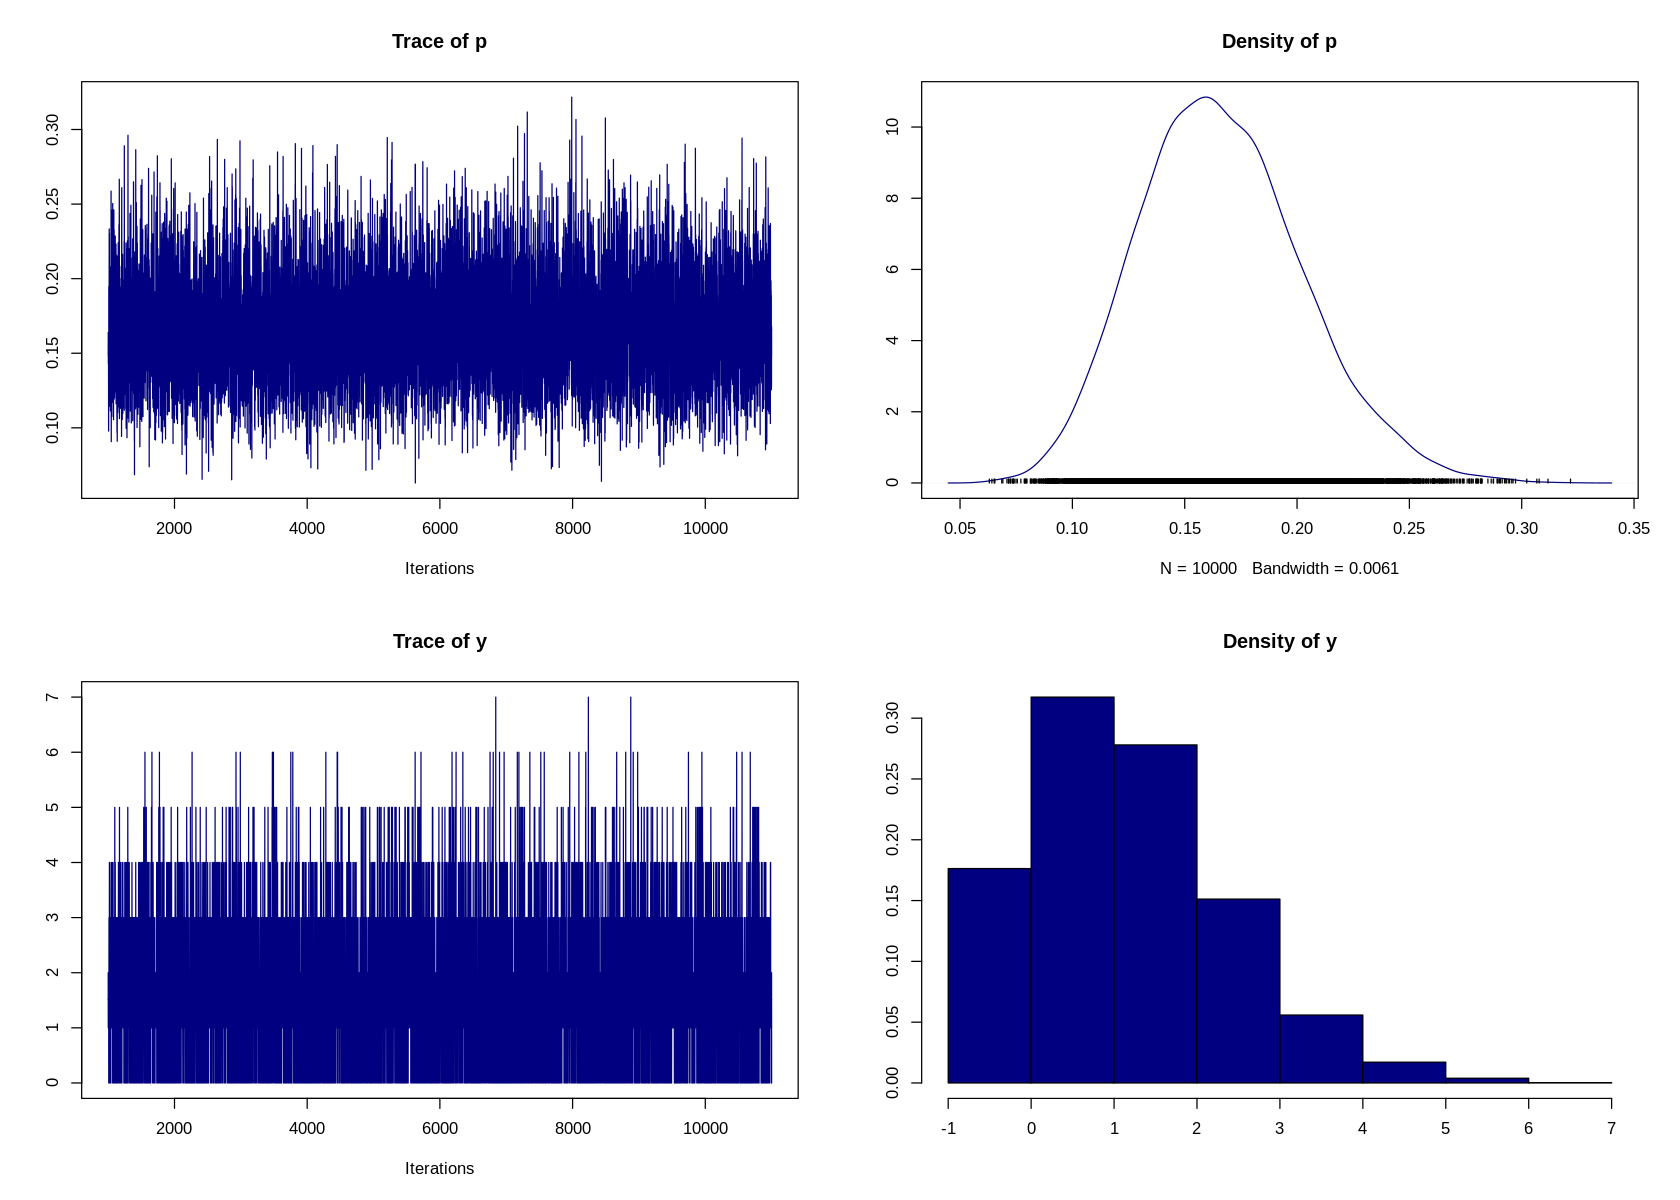

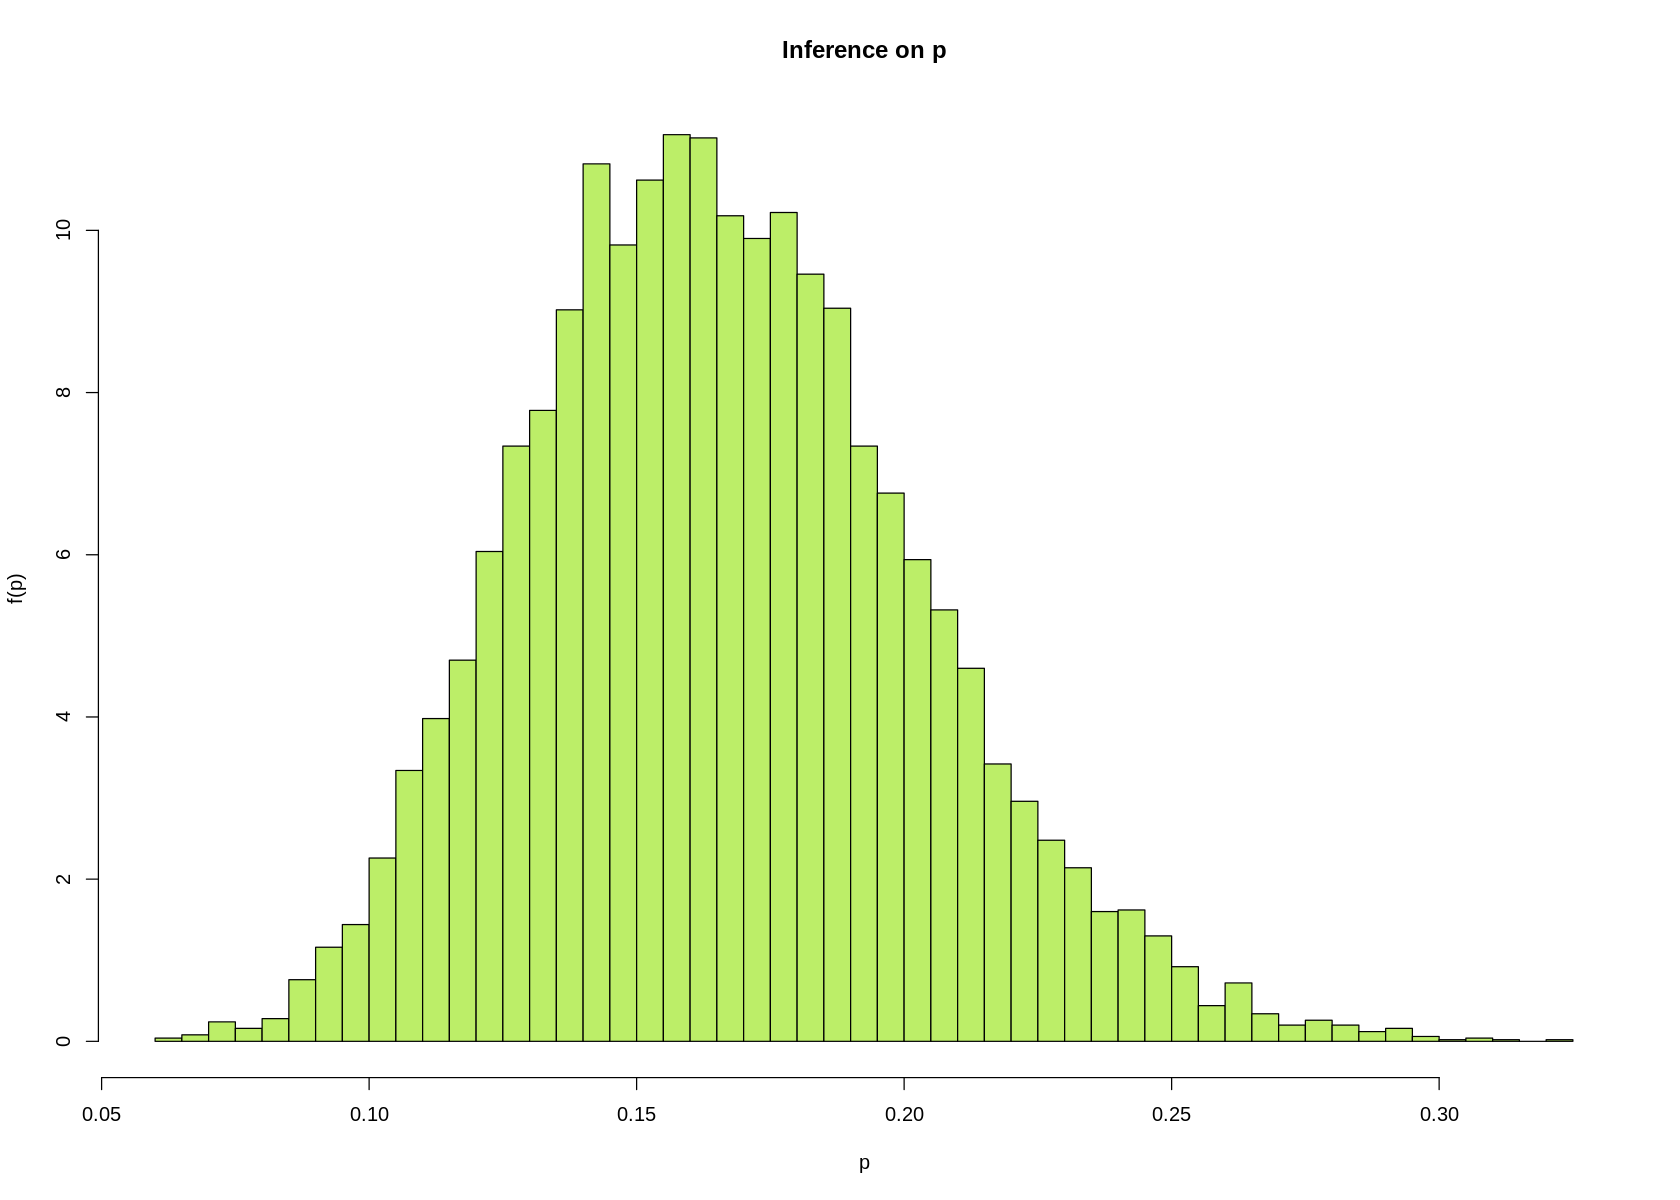

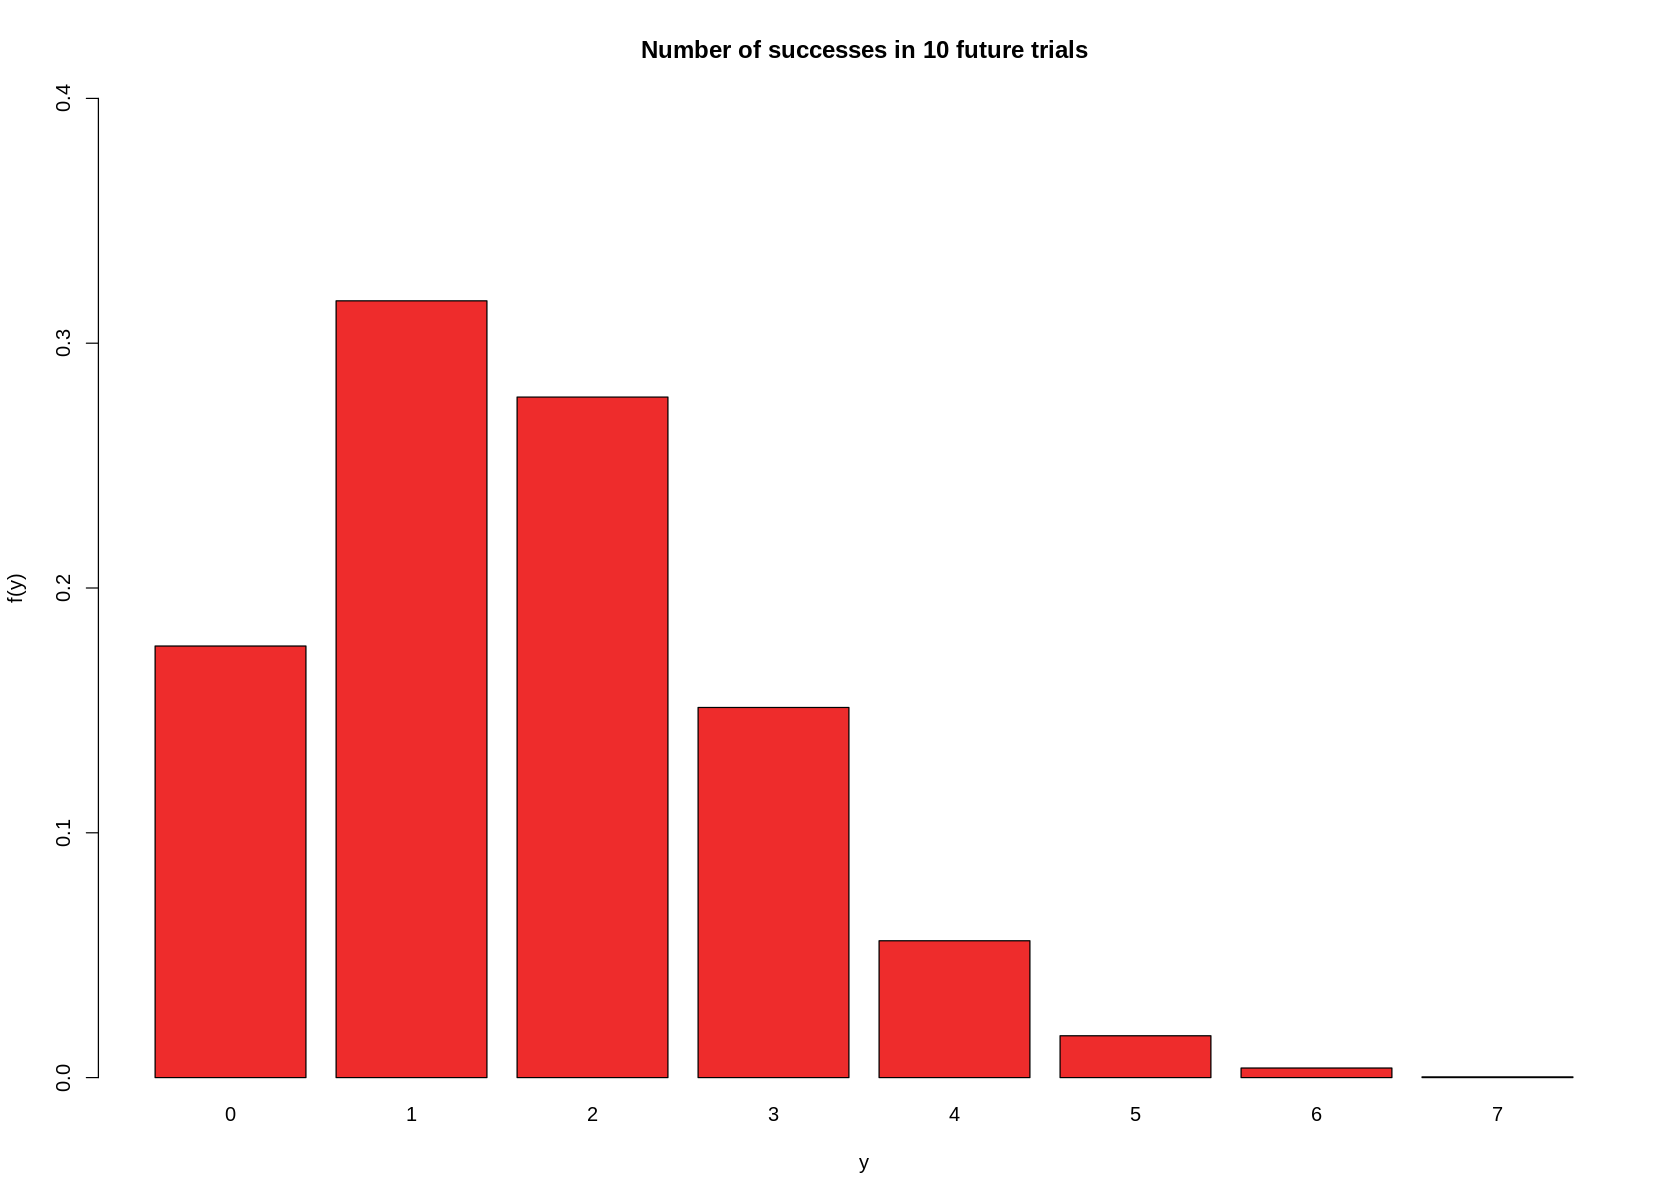

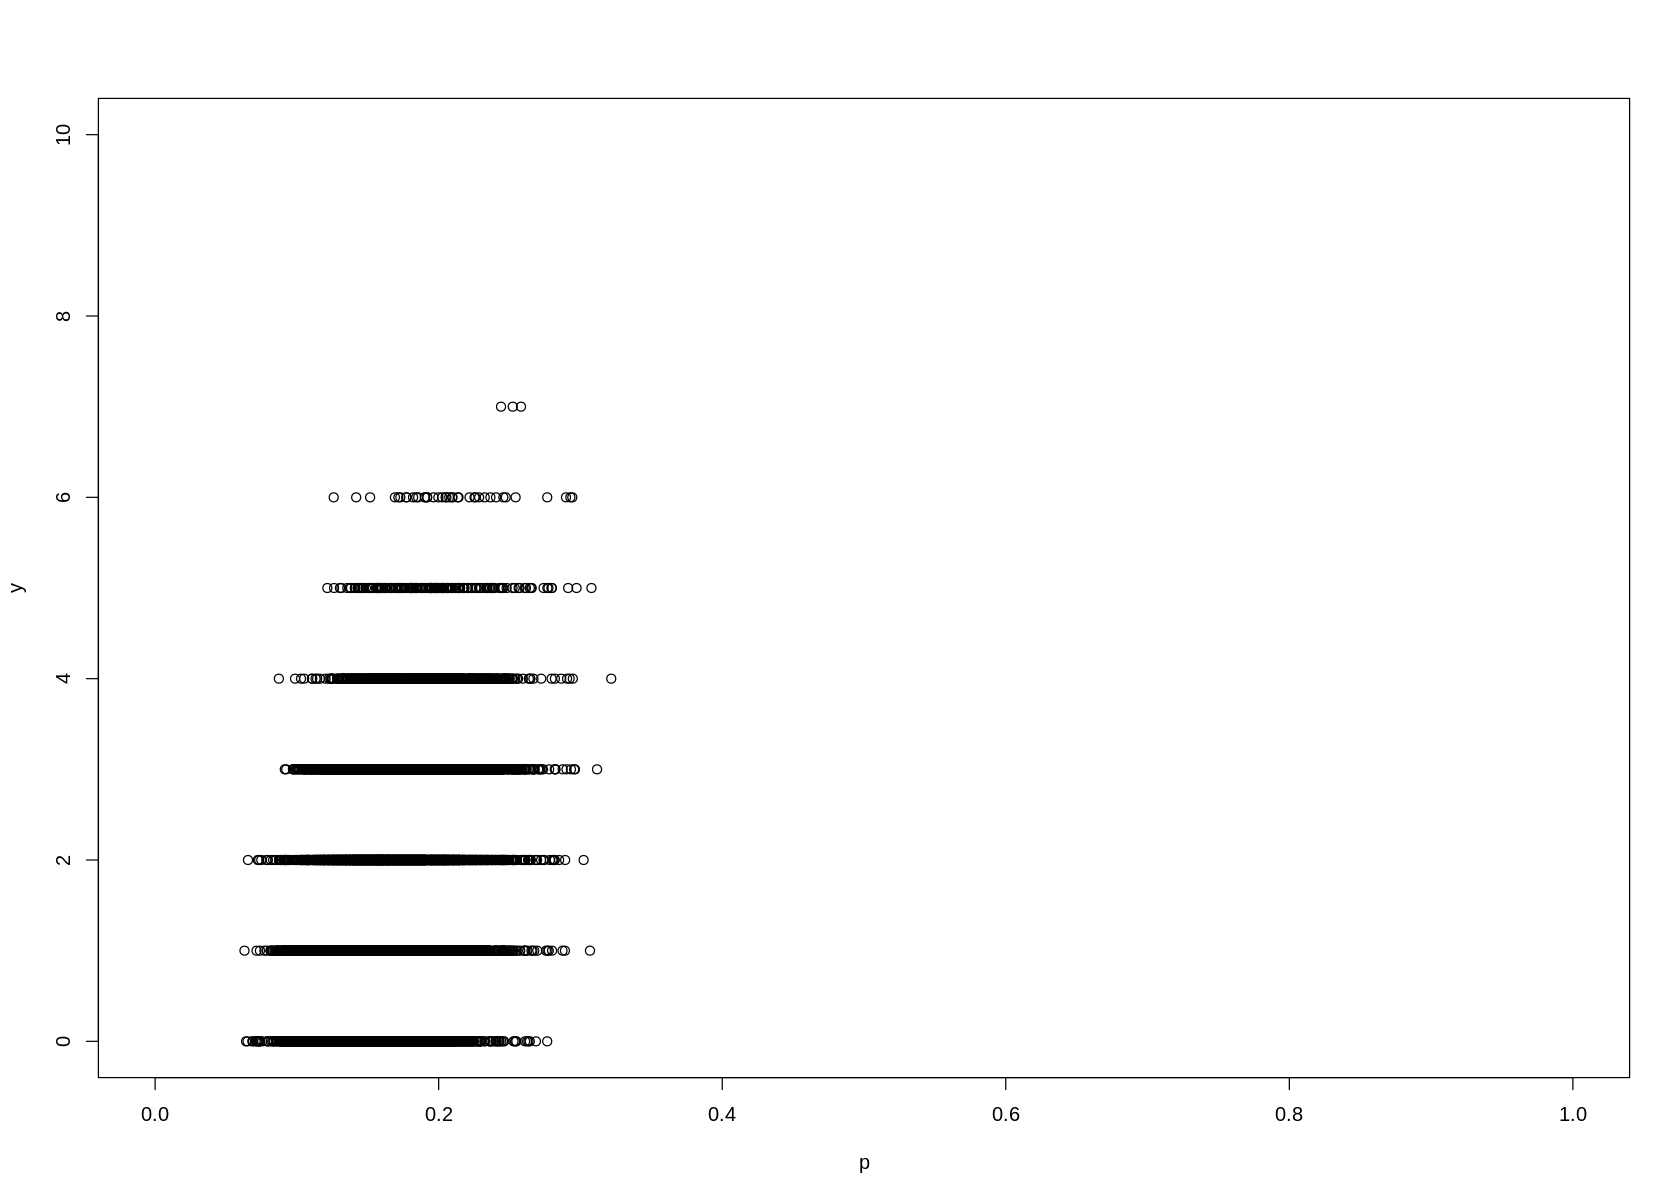

In [16]:
options(repr.plot.width=14, repr.plot.height=10)
plot(chain, col='navy')

# Let's format our chain
chain.df <- as.data.frame(as.mcmc(chain))
cat(sprintf('\n Correlation matrix: \n'))
print(cor(chain.df))

#
# p inference result
#
hist(chain.df$p, nc=50, prob=TRUE, col='darkolivegreen2', xlab='p', ylab='f(p)', main = 'Inference on p')

#
# next data prediction probability
#
ty <- table(chain.df$y)
barplot(ty/sum(ty), col='firebrick2', xlab='y', ylab='f(y)', ylim=c(0,0.40), main=sprintf('Number of successes in %d future trials', data$n_next))

#
# Correlation between p and predicted variable
#
plot(chain.df$p, chain.df$y, xlab='p', ylab='y', main='', xlim=c(0,1), ylim=c(0,10))

### 3.2 Poisson

In [19]:
data <- NULL
data$X <- 100

model <- 'jags2.bug'
jm <- jags.model(model, data)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 2
   Total graph size: 4

Initializing model



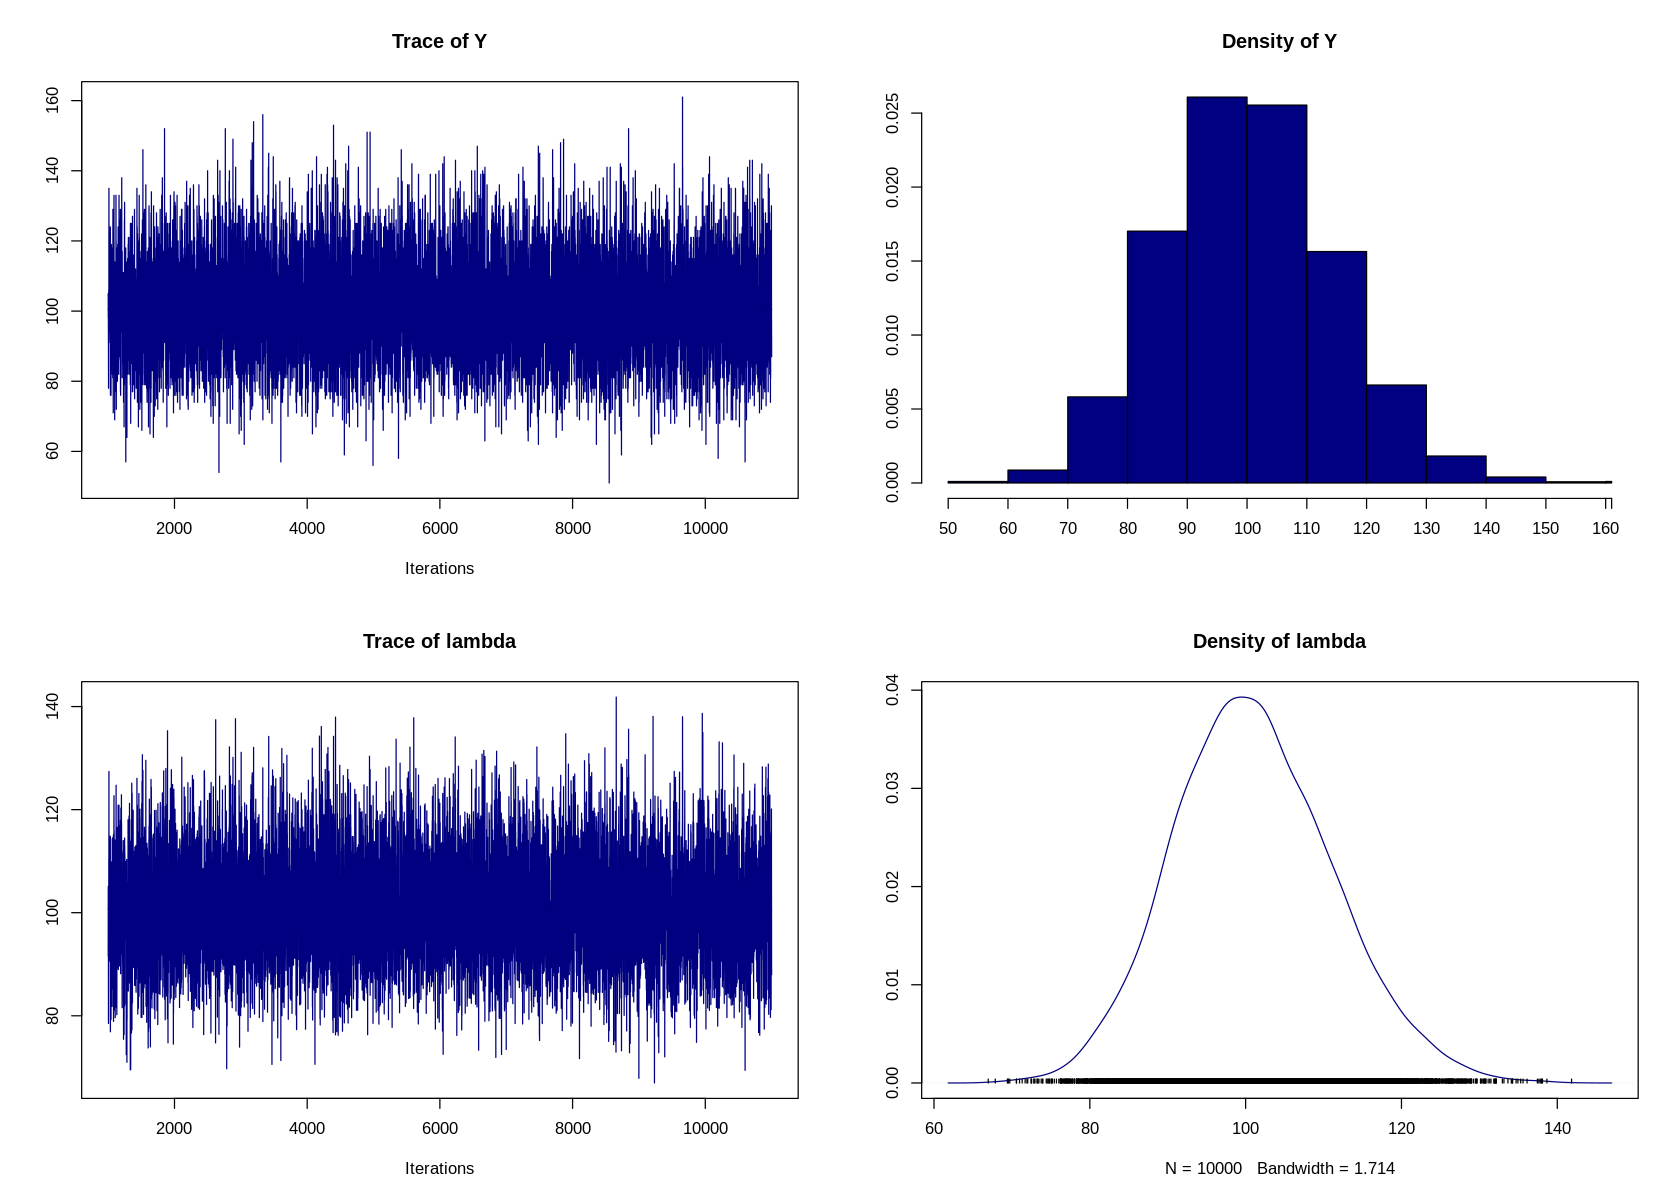

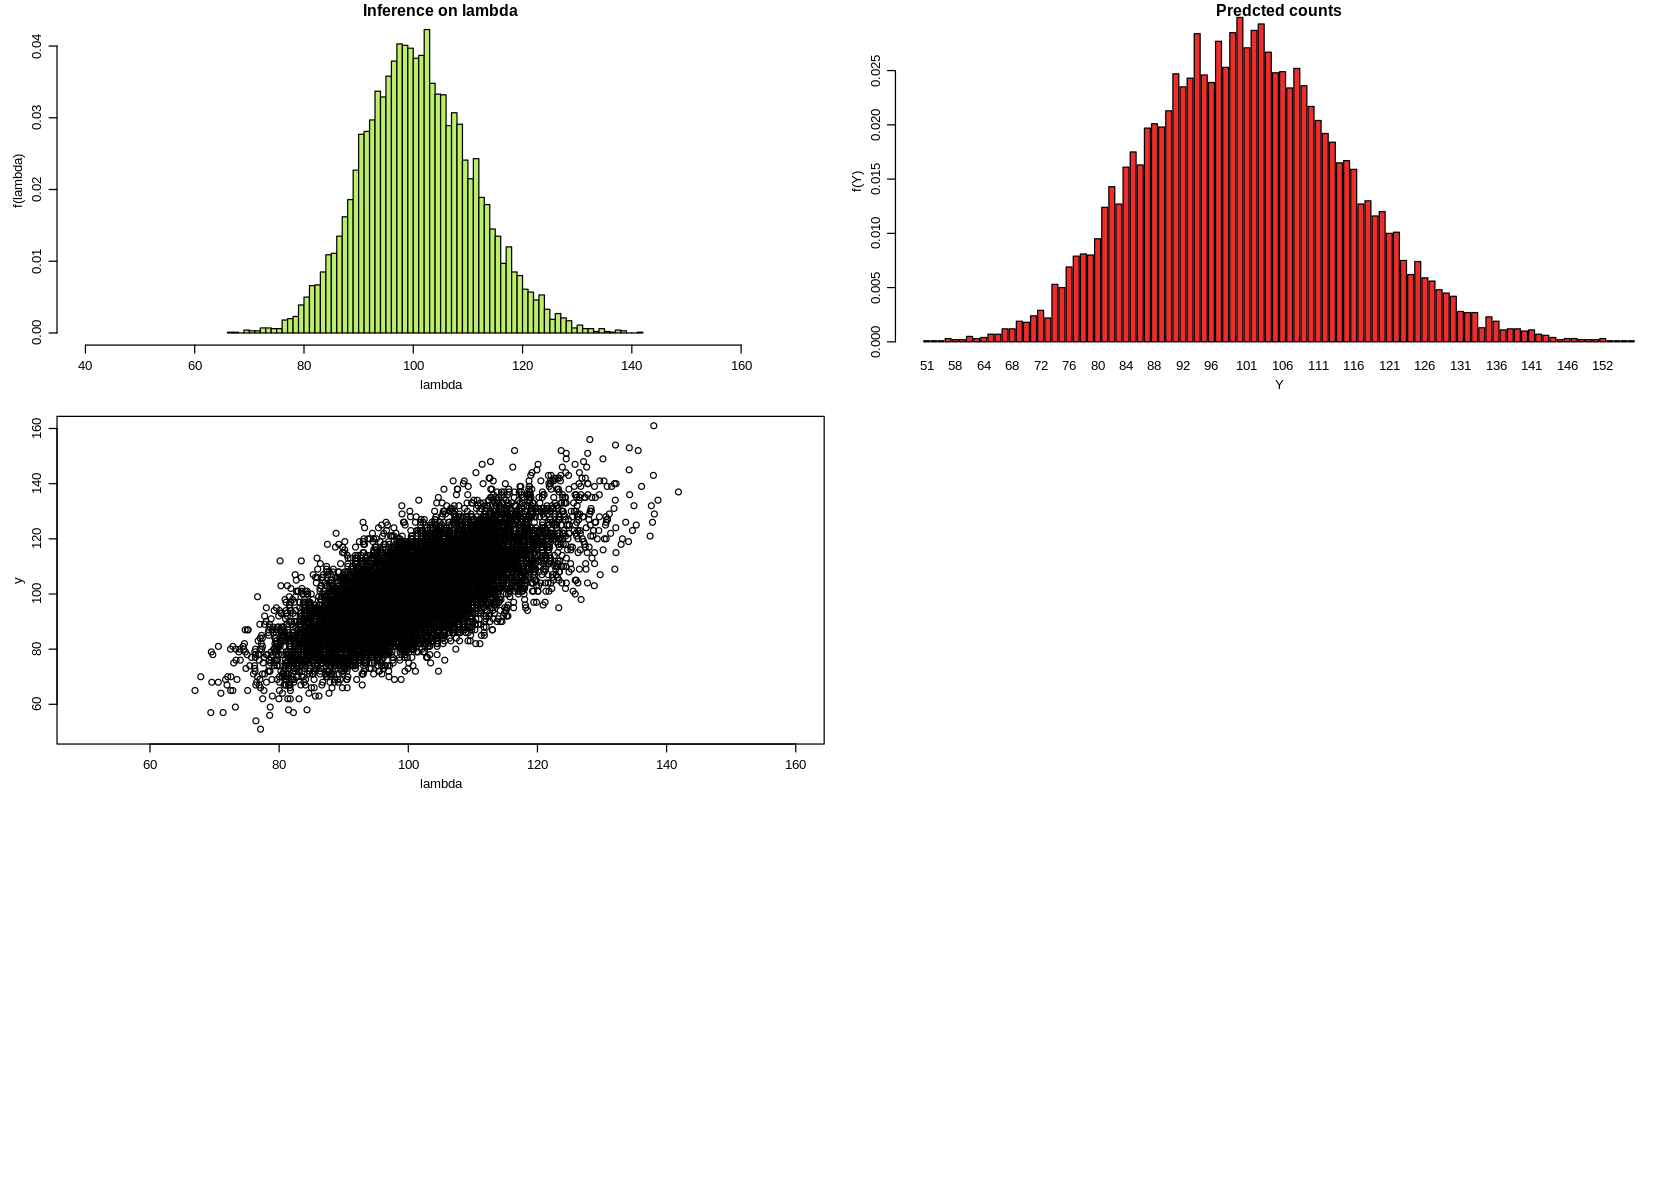

In [20]:
# Update the Markov chain (Burn-in)
update(jm, 1000)
chain <- coda.samples(jm, c('lambda', 'Y'), n.iter=10000)

plot(chain, col='navy')

chain.df <- as.data.frame(as.mcmc(chain))

#
# Probability plots
par(mfrow=c(3,2), mgp = c(2.0, 0.8, 0), mar=c(3.5,3.5,1,1), oma=0.1*c(1,1,1,1))
hist(chain.df$lambda, nc=100, prob=TRUE, col='darkolivegreen2', xlim=c(40,170), xlab='lambda', ylab='f(lambda)', main = 'Inference on lambda')

ty <- table(chain.df$Y)
barplot(ty/sum(ty), col='firebrick2', xlab='Y', ylab='f(Y)', main=sprintf('Predcted counts'))

#
# And present/ future prediction correlations
plot(chain.df$lambda, chain.df$Y, xlab='lambda', ylab='y', main='', xlim=c(50,160), ylim=c(50,160))

### 3.3 Normal

In [23]:
set.seed(20190522)

#
# Generate the observed data
data_size <- 100
data_mu <- 10
data_sigma <- 1
data_obs <- rnorm(data_size, data_mu, data_sigma)

model <- 'jags3.bug'

data <- NULL
data$X <- data_obs

jm <- jags.model(model, data)

update(jm, 1000)

chain <- coda.samples(jm, c('mu', 'sigma', 'Y'), n.iter=10000)
print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 3
   Total graph size: 109

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
Y     10.062 0.97568 0.0097568      0.0097568
mu    10.055 0.09681 0.0009681      0.0009681
sigma  0.966 0.06882 0.0006882      0.0006882

2. Quantiles for each variable:

        2.5%    25%     50%    75%  97.5%
Y     8.1587 9.4060 10.0591 10.727 11.954
mu    9.8677 9.9908 10.0551 10.120 10.247
sigma 0.8429 0.9178  0.9612  1.009  1.111



## RSTAN

### 4.1 Bernoulli example

In [3]:
library(rstan)

Loading required package: StanHeaders

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:coda’:

    traceplot


The following object is masked from ‘package:tidyr’:

    extract




In [6]:
options(mc.cores = parallel::detectCores())
parallel::detectCores()

[1] 4

In [7]:
rstan_options(auto_write = TRUE)

In [43]:
stan1data <- c('y',c(rep(0,35), rep(1,15)))
writeLines(stan1data, con='stan1_data.csv')

In [44]:
modelString =
    "data
        {
            int<lower=0> N;
            int y[N];
        }

     parameters
        {
            real<lower=0, upper=1> theta;
        }
     
     model
        {
            theta ~ beta(1,1);
            y ~ bernoulli(theta);
        }"
writeLines(modelString, con='stan1_model.txt')

In [45]:
stanDso <- stan_model(model_code = modelString)

In [47]:
# Read the data and put it in a list
myData <- read.csv("stan1_data.csv")

y <- myData$y
N <- length(y)

dataList <- list(y=y, N=N)

In [48]:
stanFit <- sampling(object=stanDso, data = dataList, chains= 3, iter= 1000, warmup = 200, thin = 1)

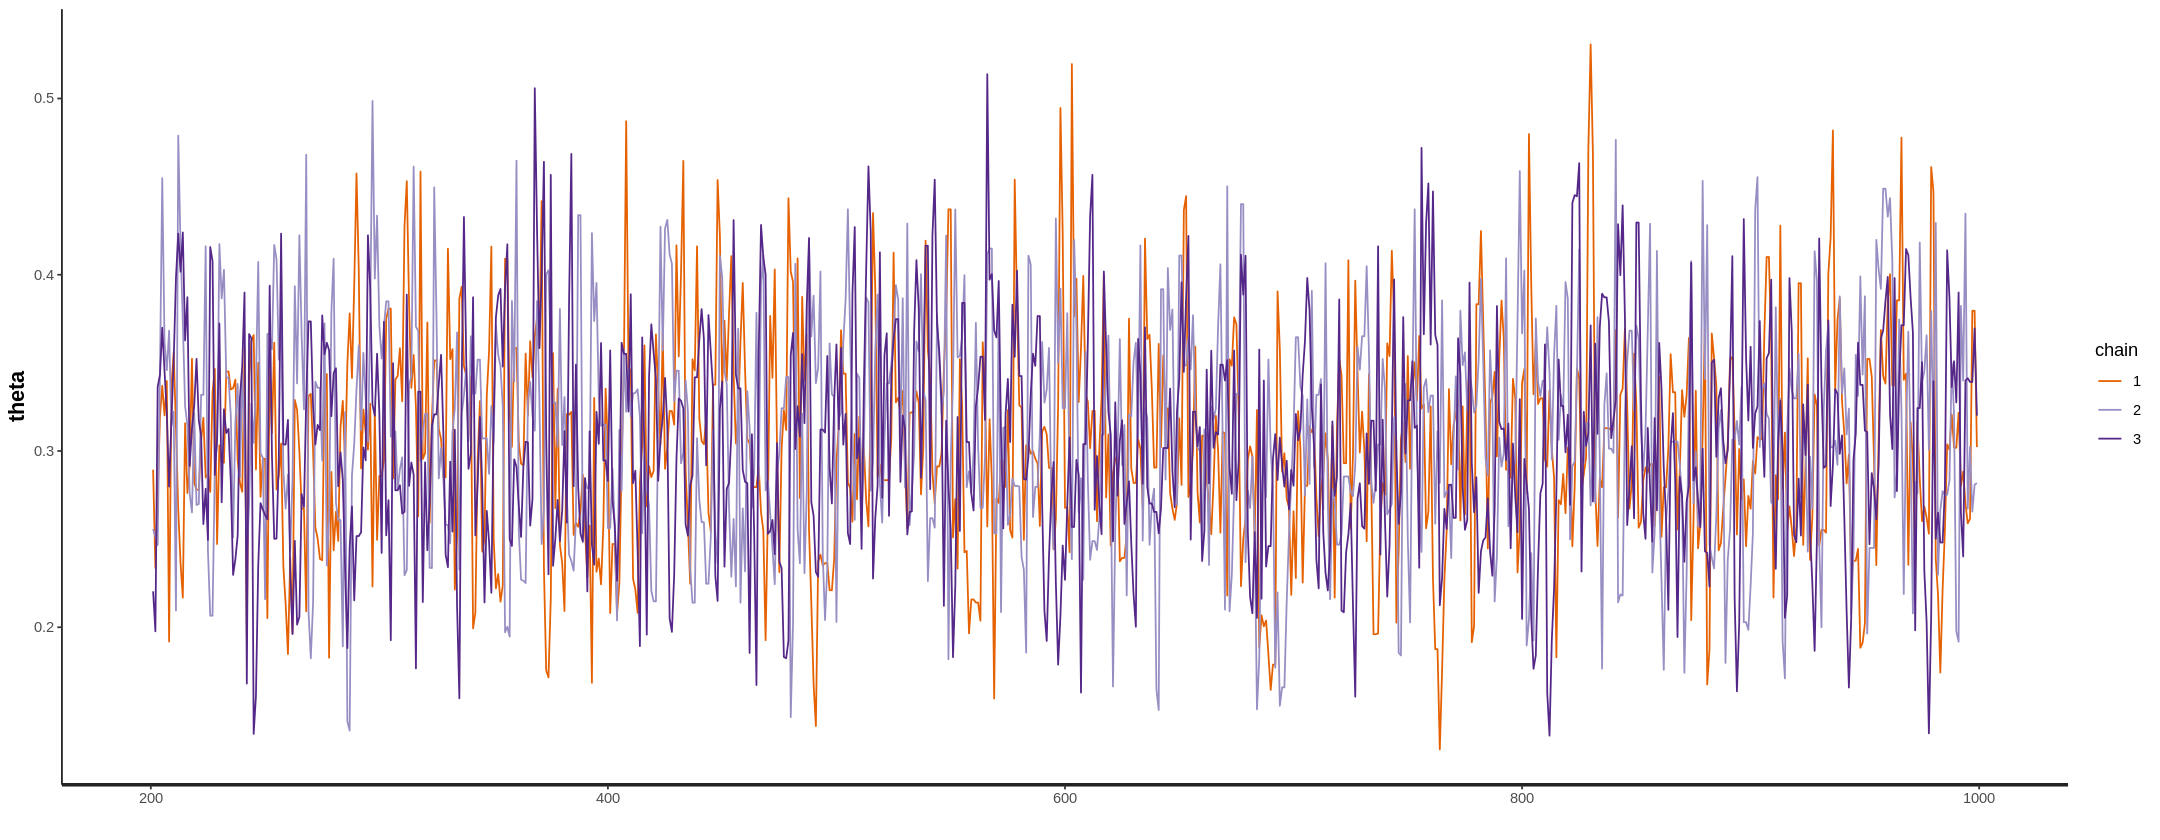

In [49]:
rstan::traceplot(stanFit,pars=c('theta'))

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



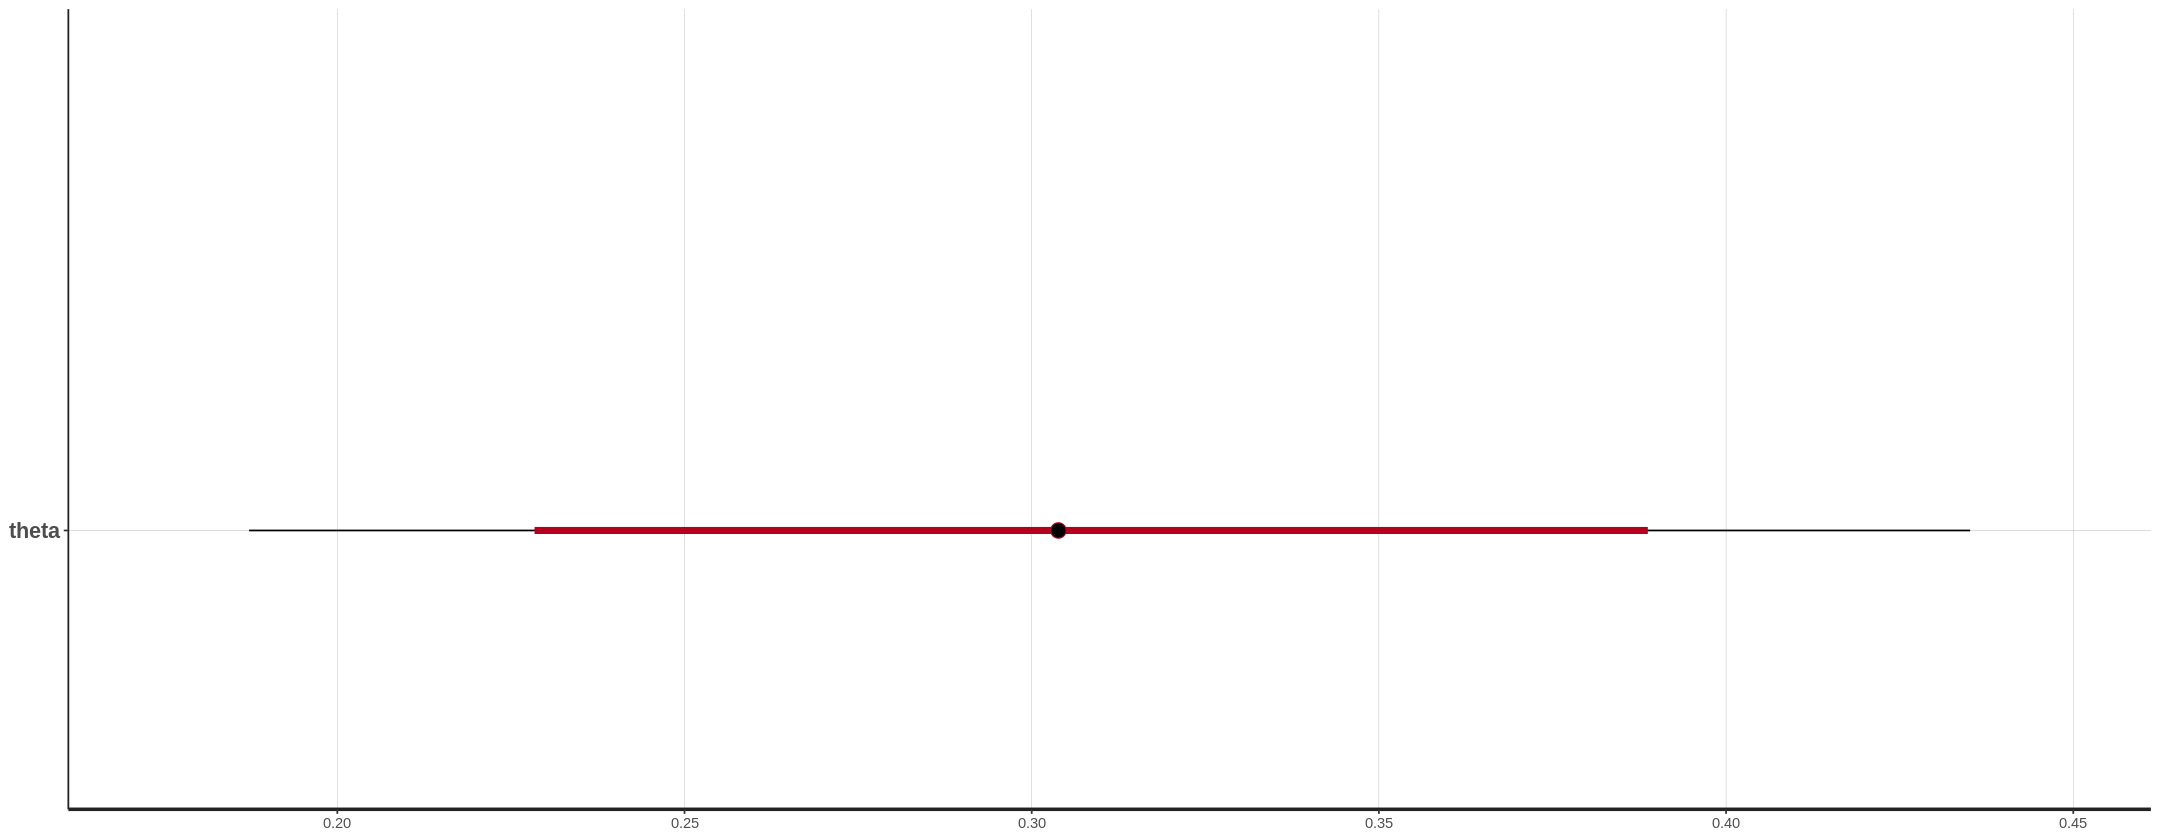

In [50]:
plot(stanFit,pars=c('theta'))

In [52]:
mcmcCoda <- mcmc.list(lapply(1:ncol(stanFit), function(x) {mcmc(as.array(stanFit)[,x,])} ) )

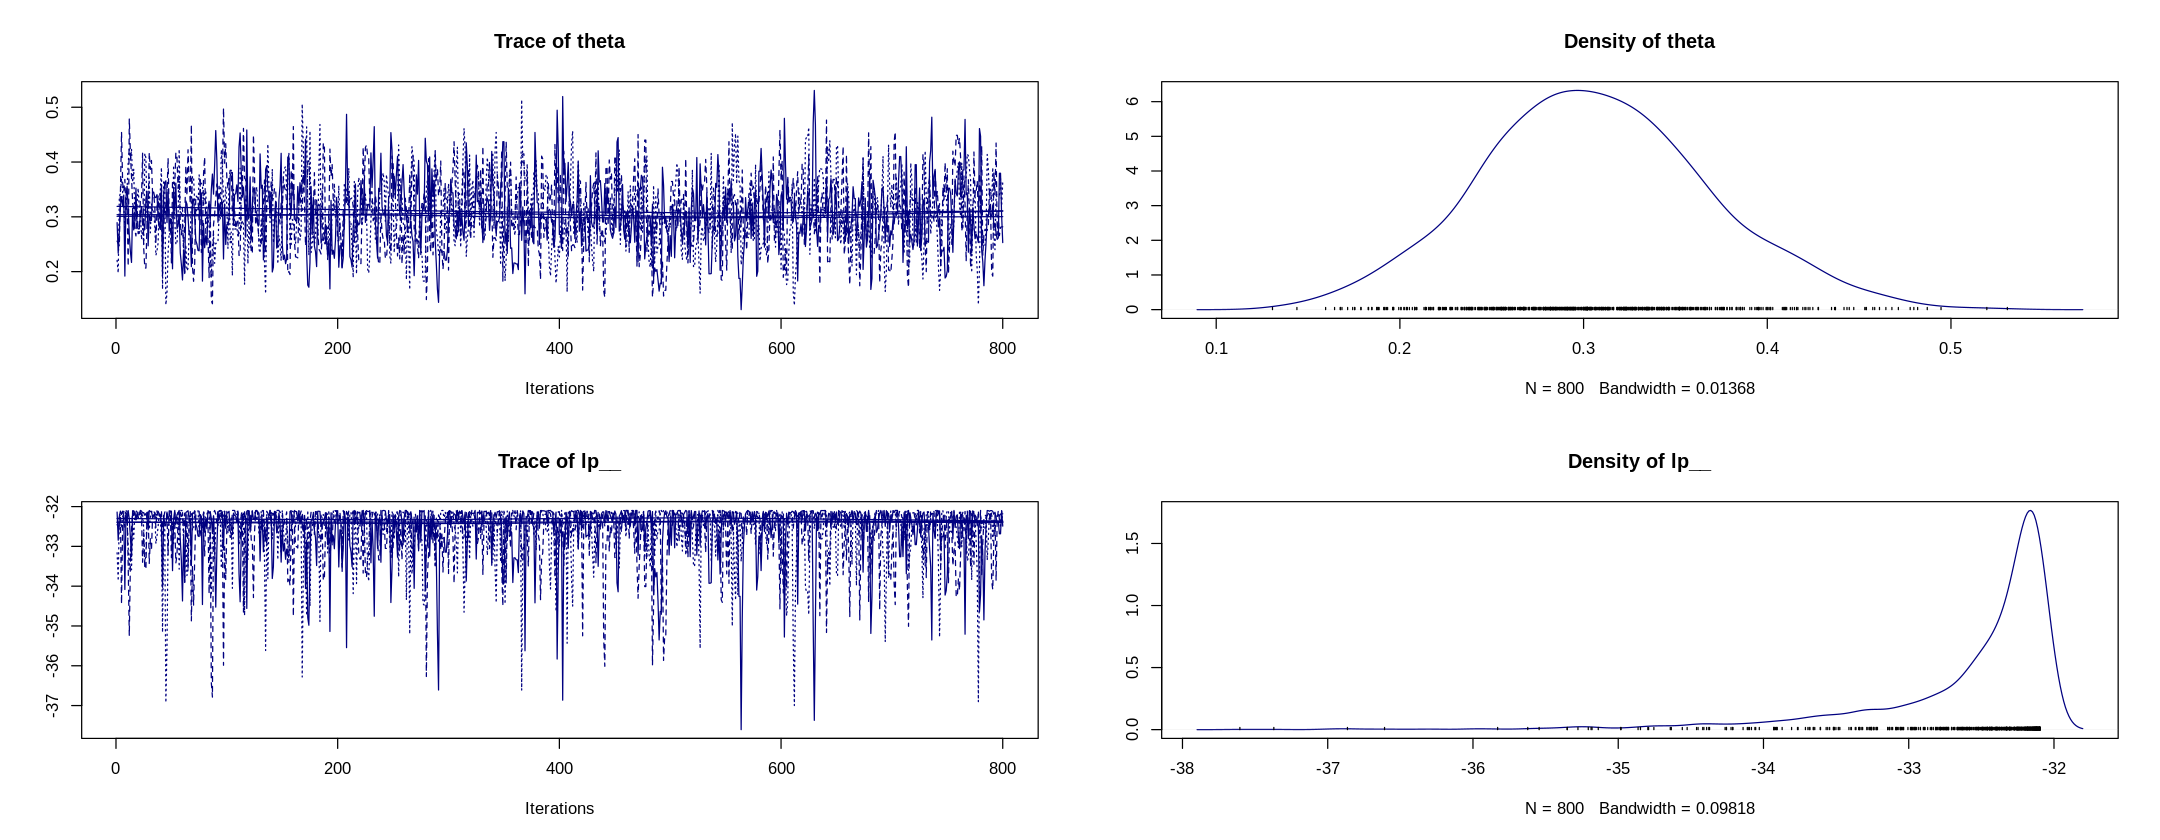

In [53]:
plot(mcmcCoda, col='navy')

## Pfizer example

In [16]:
tot_vaccine <- 21999
tot_placebo <- 21539
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))

# Number of patients tested positive after RCT
pos_vaccine <- 8
pos_placebo <- 86
tested <- c(rep("Pos", pos_vaccine),
            rep("Neg", tot_vaccine - pos_vaccine),
            rep("Pos", pos_placebo),
            rep("Neg", tot_placebo - pos_placebo))

pfizer.tb <- tibble(tested = tested, patient = patient)

table(pfizer.tb[[2]], pfizer.tb[[1]])

         
            Neg   Pos
  Placebo 21453    86
  Vaccine 21991     8

In [17]:
pfizermodelstr <-
    "model
        {
            for(i in 1:Ntot)
                {
                    tested[i] ~ dbern(theta[patient[i]])
                }
            for(k in 1:Nclass)
                {
                    theta[k] ~ dbeta(3,100)
                }
        }"
writeLines(pfizermodelstr, con='pfizer_model.txt')

In [18]:
dataList <- list(
        tested = ifelse(pfizer.tb$tested == 'Neg', 0, 1),
        patient = as.integer(factor(pfizer.tb$patient)),
        
        Ntot = nrow(pfizer.tb),
        Nclass = nlevels(factor(pfizer.tb$patient))
    )

In [19]:
library(runjags)

In [21]:
pfizer_chains <- run.jags(pfizermodelstr, sample=15000, n.chains=4, method='parallel', monitor='theta', data=dataList)

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Sun Jun  6 12:44:08 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 43538
   Unobserved stochastic nodes: 2
   Total graph size: 87082
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 15000
-------------------------------------------------| 15000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

In [23]:
summary(pfizer_chains)

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.003277390,0.004099490,0.004984480,0.0041149623,0.0004359065,NA,2.189434e-06,0.5,39639,-0.002345047,1.0000849
theta[2],0.000223908,0.000483751,0.000794665,0.0004978325,0.0001495673,NA,7.478367e-07,0.5,40000,-0.004198138,0.9999819
